# Lab 4 - transformers part 1

In this lab, we will implement a simple transformer model for sequence-to-sequence tasks using PyTorch. The transformer architecture is based on the paper "Attention is All You Need" by Vaswani et al. (2017). To undestand the key concepts of transformers, we will build the model step by step, starting from the attention mechanism and moving towards the complete transformer architecture. 

This course is mainly based on the article [Attention is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017). Additionally, for a more in-depth understanding of transformers, you can refer to the [Attention in transformers, step-by-step](https://www.youtube.com/watch?v=eMlx5fFNoYc) by 3Blue1Brown (and other chapters for Deep Learning).

### Background

As you may know, for sequence-to-sequence tasks, Recurrent Neural Networks (RNNs) and Long Short-Term Memory networks (LSTMs) have been widely used. However, these models have limitations in capturing long-range dependencies (due to the vanishing gradient problem) and are inherently sequential, making them less efficient for parallel processing.

The transformer architecture was introduced to address these limitations. Instead of relying on recurrence, transformers are built entirely on the concept of attention. Attention allows the model to focus on different parts of the input sequence when producing each output, making it possible to capture both short- and long-range dependencies efficiently. Furthermore, transformers are highly parallelizable since all tokens in a sequence can be processed simultaneously. This combination of efficiency and expressive power has made transformers the foundation of most modern natural language processing and multimodal systems.


### The Core Idea: Attention

The attention mechanism is the core idea behind transformers. It allows the model to weigh the importance of different parts of the input sequence when generating each part of the output sequence. Taking from the original paper:

> An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

To better understand this, let's break down the components:
- **Query (Q)**: represents the element we are currently trying to process. For example, when translating a word in the decoder, the query represents the “current word position” the model is focusing on.
- **Key (K)**: represents the elements in the sequence that the query can “look at.” Each token in the input (or output) sequence is assigned a key vector.
- **Value (V)**: represents the information contained in each token that can be passed along. The value is what gets aggregated to produce the attention output.

To understand how attention works, consider the library analogy:
> Imagine you are in a library looking for information on a specific topic. You have a question (the query) and you want to find relevant books (the keys) that contain the information you need (the values). The attention mechanism helps you determine which books are most relevant to your question by assigning weights to each book based on how well its content matches your query. The more relevant a book is, the higher the weight it receives. Finally, you gather information from the most relevant books (the weighted sum of values) to answer your question.

### Scaled Dot-Product Attention

<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab4_5_transformer/figures/sdpa.png width="200">

As there are many ways to implement attention, the transformer architecture uses a specific type called Scaled Dot-Product Attention. The steps to compute this attention are as follows:

$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

where:
- $QK^T$ computes the dot products between the query and all keys, resulting in a score matrix that indicates how much focus each key should receive.
- $\sqrt{d_k}$ is a scaling factor (where $d_k$ is the key dimension) that helps stabilize gradients during training, especially when the dimensionality of the keys is large.
- $\text{softmax}$ normalizes the scores into probabilities (attention weights), ensuring they sum to 1.
- The final output is a weighted sum of the values, where each value is weighted by its corresponding attention weight.

Why this is powerful?
 - Attention is content-based: instead of attending to a fixed position (like in RNNs), the model dynamically decides which tokens are most relevant.
 - Each output token can attend to all input tokens, allowing for long-range dependencies to be captured effectively.

### Multi-Head Attention

<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab4_5_transformer/figures/mha.png width="400">

So far, we have described scaled dot-product attention as a single operation:

$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

This works well, but one attention mechanism can only learn one type of relationship at a time. For example, when processing a sentence, we might want the model to pay attention to:
- grammatical structure (e.g., subject → verb connections),
- semantic meaning (e.g., “dog” relates to “animal”),
- positional patterns (e.g., word order).

A single attention head cannot capture all these aspects simultaneously.

Multi-head attention solves this by using multiple attention “heads” in parallel:
1. The input embeddings are linearly projected into multiple sets of Queries, Keys, and Values, where each Head has its own learned projection matrices.
2. Each head performs scaled dot-product attention independently, allowing each to focus on different parts of the input.
3. The outputs of all heads are concatenated and linearly transformed to produce the final output.

$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O$


### Encoder and Decoder

The original transformer architecture from the paper consists of an encoder and a decoder, each made up of multiple layers. The encoder processes the input sequence, while the decoder generates the output sequence step by step, attending both to the encoder outputs and to the tokens it has generated so far.

<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab4_5_transformer/figures/transformer.png width="400">

#### Encoder
Each encoder layer contains:
- Multi-head self-attention mechanism: allows each token in the input sequence to attend to all other tokens, capturing dependencies across the entire sequence.
- Position-wise feed-forward network (FFN): a fully connected feed-forward network applied independently to each token representation.
- Residual connections and layer normalization: improve gradient flow and stabilize training.

#### Decoder

Each decoder layer contains:
- Masked multi-head self-attention: similar to the encoder’s self-attention, but with an important difference — masking is applied so that a token at position t can only attend to tokens at positions ≤ t. This prevents the model from “cheating” by looking ahead at future tokens during training, ensuring that predictions are made autoregressively.
- Multi-head cross-attention: allows the decoder to attend to the encoder’s output sequence. This way, when generating the next token, the decoder has access not only to what it has generated so far but also to the full context of the input.
- Position-wise feed-forward network (FFN).


#### The Role of Masking

Masking is essential in the decoder’s self-attention. Without masking, when predicting the next word in a sequence, the decoder could directly attend to the ground truth future words, making the training unrealistic compared to inference time. It is implemented by setting the attention scores of future tokens to negative infinity before applying the softmax function, effectively preventing any attention to those positions.

For more details, you can watch this fragment of the video by 3Blue1Brown: [link](https://youtu.be/eMlx5fFNoYc?si=vDft5S1YYG6ivEqD&t=665)

# Implementation

Let's implement the transformer model step by step using PyTorch. We will start with the attention mechanism, then build the multi-head attention, followed by the encoder and decoder layers, and finally assemble the complete transformer model.

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from typing import Optional

import wandb

wandb.login()

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

wandb: Currently logged in as: kapiotrow (deep-neural-network-course) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


We start by defining a class Head, which represents one attention head in multi-head attention.

- `__init__`: 
    - Creates three linear layers to project the input into queries, keys, and values (emb_size -> head_size).
    - Calculate the scaling factor `scale` as the inverse square root of the head size to normalize the dot products.
    - Initializes a dropout layer to prevent overfitting.
    - Initializes a variable `attn_weights` to store the attention weights for visualization purposes.

- `scale_dot_product_attention`:
    - Computes the dot products between queries and keys to get raw attention scores (use `torch.matmul` and `.transpose`).
    - Scales the scores by the `scale` factor.
    - Applies an optional mask to prevent attending to certain positions (use `.masked_fill()` and apply `-inf` where `mask==0`).
    - Applies softmax to obtain attention weights and save it in `attn_weights` (moved to CPU for visualization).
    - Applies dropout to the attention weights.
    - Computes the final output as a weighted sum of the values using the attention weights.

- `forward`:
    - Projects the `key`, `query`, and `value` inputs using the respective linear layers.
    - Calls `scale_dot_product_attention` to compute the attention output.
    - Returns the attention output.


<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/2d41174bc3e6d8e7ab0289d983343f5e0d5157c5/lab4_5_transformer/figures/head.svg width="300">

In [2]:
# --- Single Attention Head ---
class Head(nn.Module):
    def __init__(self, emb_size, head_size, dropout=0.0, bias=False):
        super().__init__()
        self.key   = nn.Linear(emb_size, head_size, bias=bias)
        self.query = nn.Linear(emb_size, head_size, bias=bias)
        self.value = nn.Linear(emb_size, head_size, bias=bias)
        self.scale = head_size ** -0.5
        self.dropout = nn.Dropout(dropout)
        self.attn_weights = None

    def forward(self, q, k, v, mask=None):
        Q = self.query(q)
        K = self.key(k)
        V = self.value(v)
        return self.scaled_dot_product_attention(Q, K, V, mask)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        self.attn_weights = attn.detach().cpu()
        attn = self.dropout(attn)
        out = torch.matmul(attn, V)
        return out

We define a class MultiHeadAttention, which combines several attention heads to allow the model to learn from different types of relationships in parallel.

- `__init__`: 
    - Asserts that the embedding size is divisible by the number of heads.
    - Calculates the size of each head as `emb_size // num_heads`.
    - Creates a list of `Head` instances, each initialized with the embedding size and head size (use `nn.ModuleList([])`).
    - Initializes a linear layer to combine the outputs of all heads back into the original embedding size.
    - Initializes a dropout layer to prevent overfitting.

- `forward`:
    - Passes the `key`, `query`, and `value` inputs through each attention head and collects their outputs.
    - Concatenates the outputs of all heads along the last dimension.
    - Projects the concatenated output back to the original embedding size using the linear layer.
    - Applies dropout to the final output.
    - Returns the final output.

- `get_attention_weights`:
    - Returns the attention weights from each head for visualization purposes. Creates a list of attention weights from each head using a list comprehension.

<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab4_5_transformer/figures/mha.png width="200">

In [3]:
# --- Multi-Head Attention ---
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout=0.0, bias=False):
        super().__init__()
        assert emb_size % num_heads == 0
        head_size = emb_size // num_heads
        self.heads = nn.ModuleList([Head(emb_size, head_size, dropout=dropout, bias=bias) for _ in range(num_heads)])
        self.linear = nn.Linear(emb_size, emb_size, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        out = torch.cat([h(q, k, v, mask) for h in self.heads], dim=-1)
        out = self.linear(out)
        return self.dropout(out)

    def get_attention_maps(self):
        return [h.attn_weights for h in self.heads if h.attn_weights is not None]

We define a class EncoderBlock, which represents one layer of the transformer encoder. Each block refines token embeddings by applying self-attention and a feed-forward network.

- `__init__`: 
    - Initializes a multi-head self-attention layer with the specified embedding size and number of heads.
    - Initializes two `LayerNorm` normalization layers to stabilize training.
    - Creates a feed-forward network (FFN) consisting of two linear layers with a ReLU activation in between. The first layer expands the embedding size by a factor of `expansion`, and the second layer projects it back to the original size (emb_size -> emb_size * expansion -> emb_size). Use `nn.Sequential`.
- `forward`:
    - Applies multi-head self-attention to the input `x`, using `x` as the query, key, and value. (We use `x` for all three since it's self-attention.)
    - Adds a residual connection by summing the attention output with the original input `x`, followed by first layer normalization.
    - Passes the result through the feed-forward network (FFN).
    - Adds another residual connection by summing the FFN output with its input, followed by second layer normalization.
    - Returns the final output.

<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab4_5_transformer/figures/encoder.png width="200">

In [ ]:
# --- Encoder Block ---
class EncoderBlock(nn.Module):
    def __init__(self, emb_size, num_heads, dropout=0.0, expansion=4):
        super().__init__()
        self.attn = MultiHeadAttention(emb_size, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)
        self.ff = nn.Sequential(
            nn.Linear(emb_size, emb_size * expansion), 
            nn.ReLU(), 
            nn.Linear(emb_size * expansion, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        attn_out = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

We define a class DecoderBlock, which represents one layer of the transformer decoder. A decoder block extends the encoder block by adding masked self-attention and cross-attention.

- `__init__`: 
    - Initializes a masked multi-head self-attention layer for the decoder to attend to its own previous outputs.
    - Initializes a multi-head cross-attention layer for the decoder to attend to the encoder's outputs if `use_cross_attn` is True; otherwise, sets it to None.
    - Initializes three `LayerNorm` normalization layers for the three sub-layers (if `use_cross_attn` is False/None, we need only two normalization layers).
    - Creates a feed-forward network (FFN) similar to the encoder block.

- `forward`:
    - First check if `use_cross_attn` is None/False and `enc_out` is not None, raise a `ValueError("Cross-attention is not enabled in this DecoderBlock.")`.
    - Applies masked multi-head self-attention to the input `x`, using `x` as the query, key, and value. The `tgt_mask` is applied to prevent attending to future tokens.
    - Adds a residual connection by summing the self-attention output with the original input `x`, followed by the first layer normalization.
    - If `enc_out` is provided (we have encoder outputs), applies multi-head cross-attention using `x` as the query and `enc_out` as the key and value.
    - Adds a residual connection by summing the cross-attention output with its input, followed by the second layer normalization.
    - Passes the result through the feed-forward network (FFN).
    - Adds another residual connection by summing the FFN output with its input, followed by the third layer normalization.
    - Returns the final output.
    
<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab4_5_transformer/figures/decoder.png width="200">

In [5]:
# --- Decoder Block ---
class DecoderBlock(nn.Module):
    def __init__(self, emb_size, num_heads, dropout=0.0, expansion=4, use_cross_attn=False):
        super().__init__()
        self.cross_attn = None
        self.self_attn = MultiHeadAttention(emb_size, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(emb_size)
        if use_cross_attn:
            self.cross_attn = MultiHeadAttention(emb_size, num_heads, dropout=dropout)
            self.norm2 = nn.LayerNorm(emb_size)
        self.norm3 = nn.LayerNorm(emb_size)
        self.ff = nn.Sequential(
            nn.Linear(emb_size, emb_size * expansion),
            nn.ReLU(),
            nn.Linear(emb_size * expansion, emb_size)
        )

    def forward(self, x, 
                enc_out: Optional[torch.Tensor]=None, 
                tgt_mask: Optional[torch.Tensor]=None):
        
        if (self.cross_attn is None or self.cross_attn is False) and enc_out is not None:
            raise ValueError("Cross-attention is not enabled in this DecoderBlock.")
        
        self_attn_out = self.self_attn(x, x, x, mask=tgt_mask)
        x = self.norm1(x + self_attn_out)

        if enc_out is not None:
            cross_attn_out = self.cross_attn(x, enc_out, enc_out)
            x = self.norm2(x + cross_attn_out)

        ff_out = self.ff(x)
        x = self.norm3(x + ff_out)
        return x

### Word Embeddings and Positional Encoding

Before we talk about positions, let’s recall what embeddings are.

When we process text, words (or tokens) are first converted into word embeddings. An embedding is simply a dense vector representation of a token. Instead of treating a word as just an ID or a one-hot vector, an embedding captures semantic meaning — similar words (like “cat” and “dog”) end up with similar vector representations.

In a transformer, the first step is to look up embeddings for all input tokens. These embeddings form the semantic meaning of the sequence, but on their own, they contain no information about order.

#### Positional Encoding

Now, we have almost all the components needed to build a transformer model. Last important piece is the positional encoding.

Unlike RNNs or CNNs, the transformer has no inherent notion of sequence order — attention treats the input as a set of tokens without positional structure. However, for language and many other tasks, the order of tokens is essential (e.g. “dog bites man” ≠ “man bites dog”).

To give the model information about the positions of tokens, positional encodings are added to the input embeddings at the bottom of the encoder and decoder stacks.

There are two common approaches:
- Fixed sinusoidal encodings (original Transformer paper):
    - Use sine and cosine functions of different frequencies to encode positions.
    - Each dimension of the embedding corresponds to a sinusoid with a specific wavelength.

    Formally:
    $\text{PE}(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$
    $\text{PE}(pos, 2i+1) = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$

- Learned positional embeddings:
    - Each position has a trainable embedding vector, just like words.
    - The model learns the best positional representations during training.

#### How it's used?

The positional encodings are added to the input embeddings before feeding them into the first encoder and decoder layers. This way, each token embedding carries both its semantic meaning (from the word embedding) and its position in the sequence (from the positional encoding).

We define a class PositionalEncoding, which generates and applies positional encodings to input embeddings.


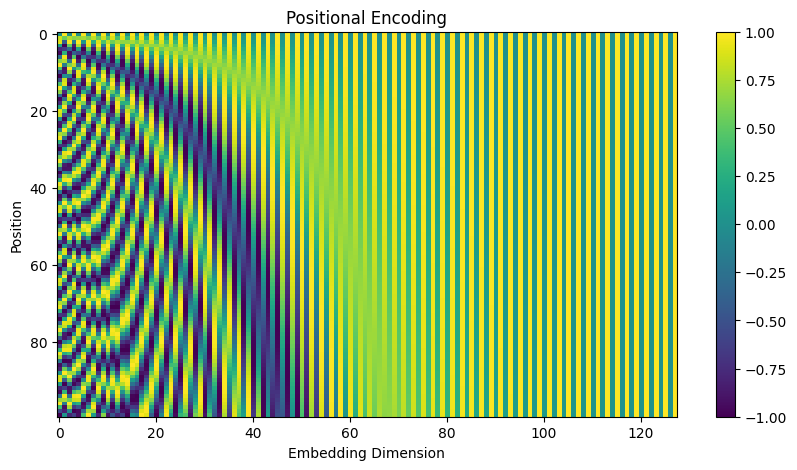

In [7]:
# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    
# Visualization of Positional Encoding
def plot_positional_encoding(pe, max_len=200):
    plt.figure(figsize=(10, 5))
    plt.imshow(pe.pe[0, :max_len].cpu(), cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    plt.title('Positional Encoding')
    plt.show()

# Example usage and visualization
d_model = 128
pe = PositionalEncoding(d_model)
plot_positional_encoding(pe, max_len=100)


Now, we will implement our own Transformer model by combining all the components we have built so far. We will use it for a simple translation task of translating digits to their corresponding English words (e.g., "123" -> "ONETWOTHREE").

We define a class NumberToWordTranslator, which implements a simple encoder-decoder transformer similar to the original architecture. Constructor gets as input: `src_vocab` - the size of the source vocabulary (digits), `tgt_vocab` - the size of the target vocabulary (words), `emb_size` - the embedding size, `num_heads` - the number of attention heads in multi-head attention, `num_layers` - the number of encoder and decoder layers.

- `__init__`: 
    - Initializes embedding layers for the source (digits) and target (words) vocabularies (use `nn.Embedding` with corresponding size of the source/target and output is equal to embedding size).
    - Initializes positional encoding layers for both the encoder and decoder. We use fixed sinusoidal encodings `PositionalEncoding`.
    - Creates a `ModuleList` of encoder blocks and decoder blocks, each with the specified number of layers abd embedding size.
    - Initializes a final linear layer to project the decoder output to the target vocabulary size.
- `forward`:
    - Looks up embeddings for the source (`src`) and target (`tgt`) sequences.
    - Adds positional encodings to both the source and target embeddings.
    - Passes the source embeddings through the encoder layers sequentially.
    - Passes the target embeddings through the decoder layers sequentially, using the encoder output and the target mask `tgt_mask` to prevent attending to future tokens.
    - Projects the final decoder output to the target vocabulary size using the linear layer. Apply `log_softmax` to get log-probabilities for each token in the target vocabulary.

In [12]:
# ===== Full Translator =====
class NumberToWordTranslator(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, emb_size=64, num_heads=2, num_layers=1, use_cross_attn=False):
        super().__init__()
        self.src_emb = nn.Embedding(src_vocab, emb_size)
        self.tgt_emb = nn.Embedding(tgt_vocab, emb_size)
        self.pos = PositionalEncoding(emb_size)
        self.encoder = nn.ModuleList([
            EncoderBlock(emb_size, num_heads)
            for _ in range(num_layers)
        ])
        self.decoder = nn.ModuleList([
            DecoderBlock(emb_size, num_heads, use_cross_attn=use_cross_attn)
            for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(emb_size, tgt_vocab)

    def forward(self, src, tgt_in, tgt_mask=None):
        src = self.src_emb(src)
        src = self.pos(src)
        for layer in self.encoder:
            src = layer(src)

        tgt = self.tgt_emb(tgt_in)
        for layer in self.decoder:
            tgt = layer(tgt, enc_out=src, tgt_mask=tgt_mask)

        out = self.fc_out(tgt)
        out = F.log_softmax(out, dim=-1)
        return out

To generate our dataset, we will create a simple function that generates random sequences of digits and their corresponding English word representations. 

1. `letters` includes the words for digits from 0 to 9 and a special `<BOS>` token to indicate the start of a sequence.
2. `letter2idx` and `idx2letter` are dictionaries to map between words and their corresponding indices.
3. `encode_word_sequence` converts a sequence of numbers, into their corresponding word indices.
4. `generate_data` creates a dataset of random digit sequences and their word representations, returning them as tensors. `src` contains sequences of digits, `tgt_out` contains the target sequences we want to predict (words), and `tgt_in` contains the input sequences to the decoder (words shifted right with a `<BOS>` token at the start). 

<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/2d41174bc3e6d8e7ab0289d983343f5e0d5157c5/lab4_5_transformer/figures/pipeline.svg width="500">

In [13]:
# ===== Dataset generator =====
mapping = {
    0: "ZERO", 1: "ONE", 2: "TWO", 3: "THREE", 4: "FOUR",
    5: "FIVE", 6: "SIX", 7: "SEVEN", 8: "EIGHT", 9: "NINE"
}
letters = ["<BOS>"] + [chr(i) for i in range(ord("A"), ord("Z")+1)]
letter2idx = {ch:i for i,ch in enumerate(letters)}
idx2letter = {i:ch for ch,i in letter2idx.items()}

def encode_word_sequence(numbers):
    out = []
    for n in numbers:
        for ch in mapping[int(n)]:
            out.append(letter2idx[ch])
    return out

def generate_data(batch, length):
    src = torch.randint(0, 10, (batch, length))
    tgt_out_list = [encode_word_sequence(seq) for seq in src]
    max_len = max(len(seq) for seq in tgt_out_list)
    tgt_out = torch.zeros((batch, max_len), dtype=torch.long)
    tgt_in  = torch.zeros((batch, max_len), dtype=torch.long)
    for i, seq in enumerate(tgt_out_list):
        tgt_out[i,:len(seq)] = torch.tensor(seq)
        tgt_in[i,1:len(seq)] = torch.tensor(seq[:-1])  # shifted with <BOS>=0
    return src, tgt_in, tgt_out

# Example usage
src, tgt_in, tgt_out = generate_data(batch=1, length=3)
print("Source (numbers):", src)
print("Target Output (words) idx:", tgt_out)
print("Target Output (words) letter:", [idx2letter[tgt_out[0,i].item()] for i in range(tgt_out.size(1))])
print("Target Input (words with <BOS>) idx:", tgt_in)
print("Target Input (words with <BOS>) letter:", [idx2letter[tgt_in[0,i].item()] for i in range(tgt_in.size(1))])

Source (numbers): tensor([[4, 6, 5]])
Target Output (words) idx: tensor([[ 6, 15, 21, 18, 19,  9, 24,  6,  9, 22,  5]])
Target Output (words) letter: ['F', 'O', 'U', 'R', 'S', 'I', 'X', 'F', 'I', 'V', 'E']
Target Input (words with <BOS>) idx: tensor([[ 0,  6, 15, 21, 18, 19,  9, 24,  6,  9, 22]])
Target Input (words with <BOS>) letter: ['<BOS>', 'F', 'O', 'U', 'R', 'S', 'I', 'X', 'F', 'I', 'V']


We implement a function `make_casual_mask` to create a causal mask for the decoder's self-attention mechanism. This mask ensures that each position in the target sequence can only attend to previous positions and itself, preventing the model from "cheating" by looking ahead at future tokens during training.

Why this mask is triangular?
The mask is triangular because it enforces a causal structure in the attention mechanism. In sequence-to-sequence tasks, when predicting the next token in a sequence, the model should not have access to future tokens. The triangular mask achieves this by allowing each position to attend only to itself and all previous positions, while masking out (setting to zero) any future positions. 

<img src=https://raw.githubusercontent.com/vision-agh/DNN-Course-media/2d41174bc3e6d8e7ab0289d983343f5e0d5157c5/lab4_5_transformer/figures/mask.svg width="300">

In [14]:
# ===== Causal Mask and Attention Visualization =====
def make_causal_mask(seq_len):
    return torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)

def plot_attn(attn_maps, title="Cross-attention"):
    num_heads = len(attn_maps)
    fig, axes = plt.subplots(1, num_heads, figsize=(num_heads*4,4))
    if num_heads == 1:
        axes = [axes]
    for i, attn in enumerate(attn_maps):
        axes[i].imshow(attn[0], cmap='viridis', aspect='auto')
        axes[i].set_title(f"{title} - Head {i+1}")
        axes[i].set_xlabel("Key positions")
        axes[i].set_ylabel("Query positions")
    plt.tight_layout()
    plt.show()
    plt.close()

# Training the Model

The training loop will involve generating batches of data, passing them through the model, computing the loss, and updating the model parameters using backpropagation.
We will use the Adam optimizer and Cross-Entropy loss for training. Additionally, we will log the training loss with attention maps to Weights & Biases (wandb) for monitoring.

In [15]:
src_vocab = 10
tgt_vocab = len(letters)  # 27
model = NumberToWordTranslator(src_vocab, tgt_vocab, emb_size=64, num_heads=2, num_layers=2, use_cross_attn=True).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

print(model)

NumberToWordTranslator(
  (src_emb): Embedding(10, 64)
  (tgt_emb): Embedding(27, 64)
  (pos): PositionalEncoding()
  (encoder): ModuleList(
    (0-1): 2 x EncoderBlock(
      (attn): MultiHeadAttention(
        (heads): ModuleList(
          (0-1): 2 x Head(
            (key): Linear(in_features=64, out_features=32, bias=False)
            (query): Linear(in_features=64, out_features=32, bias=False)
            (value): Linear(in_features=64, out_features=32, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=64, bias=True)
        (3)

Step 0, loss 0.0002
Step 100, loss 0.0002
Step 200, loss 0.0002
Step 300, loss 0.0001
Step 400, loss 0.0001
Step 500, loss 0.0001
Step 600, loss 0.0001
Step 700, loss 0.0001
Step 800, loss 0.0001
Step 900, loss 0.0001
Step 1000, loss 0.0001
Step 1100, loss 0.0001
Step 1200, loss 0.0001
Step 1300, loss 0.0001
Step 1400, loss 0.0001
Step 1500, loss 0.0001
Step 1600, loss 0.0001
Step 1700, loss 0.0001
Step 1800, loss 0.0000
Step 1900, loss 0.0000


loss,█▇▇▆▇▅▄▅▄▄▄▃▃▃▄▂▂▃▂▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁
loss,4e-05


SRC digits: [8, 5, 4, 1, 8]
TARGET letters: ['E', 'I', 'G', 'H', 'T', 'F', 'I', 'V', 'E', 'F', 'O', 'U', 'R', 'O', 'N', 'E', 'E', 'I', 'G', 'H', 'T']
PRED   letters: ['E', 'I', 'G', 'H', 'T', 'F', 'I', 'V', 'E', 'F', 'O', 'U', 'R', 'O', 'N', 'E', 'E', 'I', 'G', 'H', 'T']


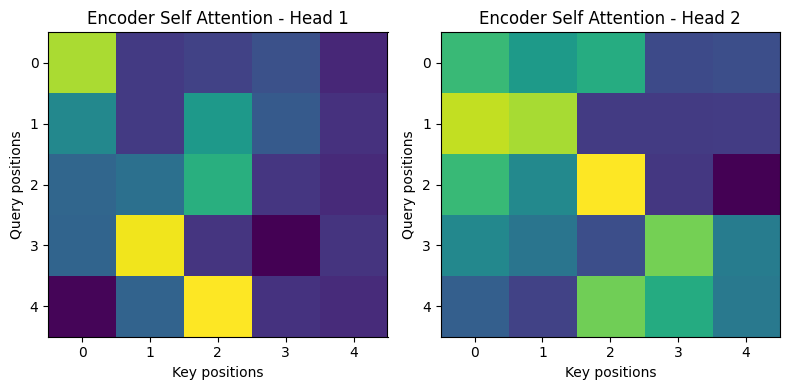

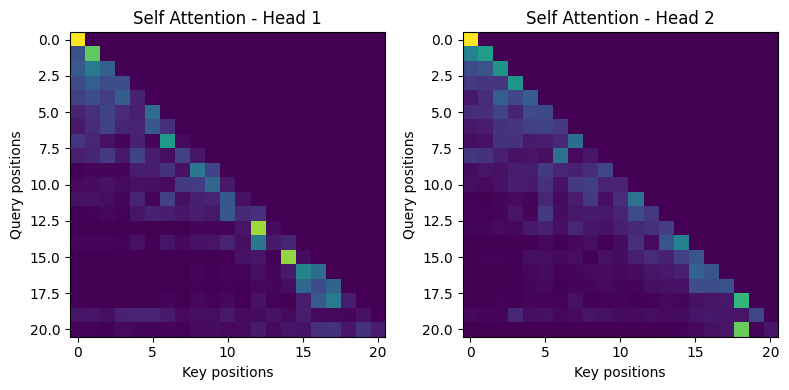

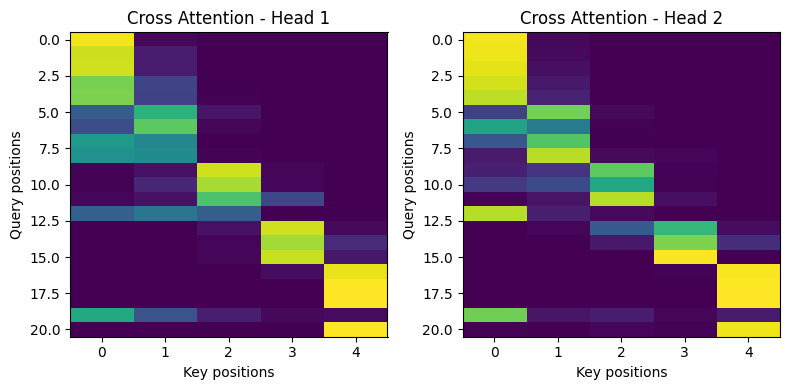

In [17]:
# ===== Training =====
wandb.init(
        project="lab4-transformer",             # do not change this line ! 
        entity="deep-neural-network-course",    # do not change this line ! 
        group="translator",                     # do not change this line ! 
        name='Karolina Piotrowska',             # change to your name 
        settings=wandb.Settings(save_code=False) # do not change this line ! 
)

for step in range(2000):
        src, tgt_in, tgt_out = generate_data(batch=16, length=5)
        tgt_mask = make_causal_mask(tgt_in.size(1))
        src, tgt_in, tgt_out, tgt_mask = src.to(device), tgt_in.to(device), tgt_out.to(device), tgt_mask.to(device)

        logits = model(src, tgt_in, tgt_mask)
        loss = loss_fn(logits.view(-1, tgt_vocab), tgt_out.view(-1))

        opt.zero_grad()
        loss.backward()
        opt.step()

        wandb.log({"loss": loss.item()})

        if step % 100 == 0:
                print(f"Step {step}, loss {loss.item():.4f}")
                # logging to wandb self attention maps
                enc_self_attn = model.encoder[-1].attn.get_attention_maps()
                for i, attn in enumerate(enc_self_attn):
                        wandb.log({f"Encoder Self Attention - Head {i+1}": wandb.Image(attn[0].numpy())})
                self_attn = model.decoder[-1].self_attn.get_attention_maps()
                for i, attn in enumerate(self_attn):
                        wandb.log({f"Self Attention - Head {i+1}": wandb.Image(attn[0].numpy())})
                cross_attn = model.decoder[-1].cross_attn.get_attention_maps()
                for i, attn in enumerate(cross_attn):
                        wandb.log({f"Cross Attention - Head {i+1}": wandb.Image(attn[0].numpy())})

wandb.finish()

# Test
src, tgt_in, tgt_out = generate_data(1, length=5)
tgt_mask = make_causal_mask(tgt_in.size(1))
src, tgt_in, tgt_out, tgt_mask = src.to(device), tgt_in.to(device), tgt_out.to(device), tgt_mask.to(device)
logits = model(src, tgt_in, tgt_mask)
pred = logits.argmax(-1)[0].tolist()

print("SRC digits:", src.tolist()[0])
print("TARGET letters:", [idx2letter[i.item()] for i in tgt_out[0] if i>0])
print("PRED   letters:", [idx2letter[i] for i in pred if i>0])

# Show self-attention maps in encoder
enc_self_attn = model.encoder[-1].attn.get_attention_maps()
plot_attn(enc_self_attn, "Encoder Self Attention")

# Show self-attention maps
self_attn = model.decoder[-1].self_attn.get_attention_maps()
plot_attn(self_attn, "Self Attention")

# Show cross-attention maps
cross_attn = model.decoder[-1].cross_attn.get_attention_maps()
plot_attn(cross_attn, "Cross Attention")
